In [1]:
import numpy
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
import matplotlib.patches as patches
import drjit as dr
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from mitsuba import Float,Point2f
from PDE2D import GreenSampling, Split

In [2]:
green = GreenSampling.Polynomial
split = Split.Normal
use_accel = True
weight_window = [0.3, 1.6]

In [3]:
source_p = {}
source_p["radius"] = 0.5
source_p["val"] = 0
def source_generator(points, params):
    return dr.select(dr.norm(points) <= params["radius"], params["val"], 0.0)

f = FunctionCoefficient("f", source_p, source_generator)
#f = ConstantCoefficient("f", 0)

In [4]:
bbox = [[-1.05, -1.05], [1.05, 1.05]]
resolution_image = [256, 256]
spp_image = 512
epsilon = 1e-5

res = 128
spp_boundary = 2 ** 18

radius = 1
computation_radius = 0.8

parameters = {}
parameters["freq"] = 2
parameters["bias"] = 6
parameters["scale"] = 12

def boundary_dirichlet_generator(points, parameters):
    angle = dr.atan2(points[0], points[1])
    return parameters["scale"] * dr.sin(angle * parameters["freq"]) + parameters["bias"]

out_val = 1

image = np.array([[0,1,2,3,4],
                  [0,1,2,3,4],
                  [0,1,2,3,4],
                  [0,1,2,3,4],
                  [0,1,2,3,4]], dtype = np.float64)
image *= 0.5
image += out_val
α = DiskTextureCoefficient("diffusion", image, radius = radius, constant_thickness= 1.01 - computation_radius, origin = [0,0], out_val = out_val)

dirichlet = FunctionCoefficient("dirichlet", parameters, boundary_dirichlet_generator)
σ = ConstantCoefficient("screening", 0)
shape = CircleShape(origin=Point2f(0., 0.), radius=radius, epsilon= epsilon,dirichlet=[dirichlet])
data_holder = DataHolder(shape = shape, α = α, σ = σ, f=f)

In [5]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (10,10))
# data_holder.visualize(ax1, ax2, ax3, ax4)

0 : 33554432 -> 4108475
1 : 4108475 -> 1963189
2 : 1963189 -> 957737
3 : 957737 -> 468413
4 : 468413 -> 228422
5 : 228422 -> 111696
6 : 111696 -> 54535
7 : 54535 -> 26863
8 : 26863 -> 13159
9 : 13159 -> 6222
10 : 6222 -> 3042
11 : 3042 -> 1491
12 : 1491 -> 654
13 : 654 -> 342
14 : 342 -> 184
15 : 184 -> 99
16 : 99 -> 47
17 : 47 -> 36
18 : 36 -> 23
19 : 23 -> 13
20 : 13 -> 8
21 : 8 -> 2
22 : 2 -> 0


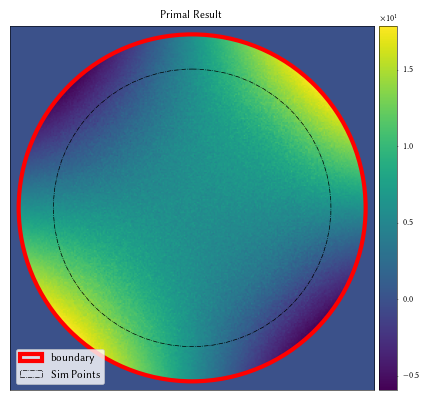

In [7]:
points = create_image_points(bbox, resolution_image, spp_image)
wos = WosVariable(data_holder, green_sampling=green, use_accelaration=use_accel, weight_window=weight_window)
#print(wos.screened)
L,_ = wos.solve(points_in = points, split = split)
image_0, tensor = create_image_from_result(L, resolution_image)
fig, (ax1) = plt.subplots(1, 1, figsize=[5, 5])
plot_image(image_0[0], ax1)
ax1.set_title("Primal Result")
shape.sketch(ax1, bbox, resolution_image)
rplot =  computation_radius * resolution_image[0] / (bbox[1][1] - bbox[0][1])
sphere = patches.Ellipse([resolution_image[0]/2 - 0.5, resolution_image[0]/2 -0.5], 
                         rplot * 2, rplot * 2, 
                         fill = False, color = "black", label = "Sim Points", ls="-.")
ax1.add_patch(sphere)
ax1.legend(loc = "lower left", fontsize = 8)

In [8]:

points, _, normal_dir = shape.create_boundary_points(distance=radius - computation_radius, res = res, spp = spp_boundary)
L, _ = wos.solve(points_in = points)
tensor, tensor_mi = shape.create_boundary_result(L, resolution = res)
boundary_dirichlet = shape.create_boundary_coefficient(tensor_mi)

0 : 33554432 -> 2633355


1 : 2633355 -> 1256127
2 : 1256127 -> 611536
3 : 611536 -> 298236
4 : 298236 -> 145556
5 : 145556 -> 71040
6 : 71040 -> 34860
7 : 34860 -> 17144
8 : 17144 -> 8299
9 : 8299 -> 4161
10 : 4161 -> 2118
11 : 2118 -> 1032
12 : 1032 -> 511
13 : 511 -> 221
14 : 221 -> 114
15 : 114 -> 46
16 : 46 -> 39
17 : 39 -> 17
18 : 17 -> 6
19 : 6 -> 2
20 : 2 -> 1
21 : 1 -> 0


In [9]:

L, p = wos.solve(points_in = points, derivative_dir = -dr.normalize(points))
tensor, tensor_mi = shape.create_boundary_result(L, resolution = res)
boundary_neumann= shape.create_boundary_coefficient(tensor_mi)

0 : 33554432 -> 2702278
1 : 2702278 -> 1290729
2 : 1290729 -> 628369
3 : 628369 -> 306612
4 : 306612 -> 149346
5 : 149346 -> 72431
6 : 72431 -> 35453
7 : 35453 -> 17317
8 : 17317 -> 8516
9 : 8516 -> 4177
10 : 4177 -> 2014
11 : 2014 -> 1016
12 : 1016 -> 437
13 : 437 -> 190
14 : 190 -> 97
15 : 97 -> 67
16 : 67 -> 43
17 : 43 -> 17
18 : 17 -> 14
19 : 14 -> 6
20 : 6 -> 9
21 : 9 -> 5
22 : 5 -> 5
23 : 5 -> 4
24 : 4 -> 0


Text(0.5, 1.0, 'Dirichlet Cut')

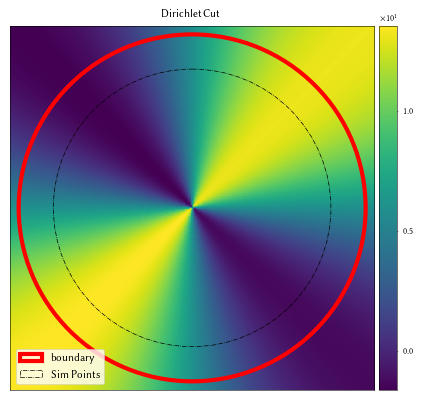

In [11]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
boundary_dirichlet[0].visualize(ax, bbox, resolution= resolution_image)
shape.sketch(ax, bbox, resolution_image)
ax.legend(loc="lower left", fontsize=8)
rplot =  computation_radius * resolution_image[0] / (bbox[1][1] - bbox[0][1])
sphere = patches.Ellipse([resolution_image[0]/2 - 0.5, resolution_image[0]/2 -0.5], 
                         rplot * 2, rplot * 2, 
                         fill = False, color = "black", label = "Sim Points", ls="-.")
ax.add_patch(sphere)
ax.legend(loc = "lower left", fontsize = 8)
ax.set_title("Dirichlet Cut")

Text(0.5, 1.0, 'Neumann Cut')

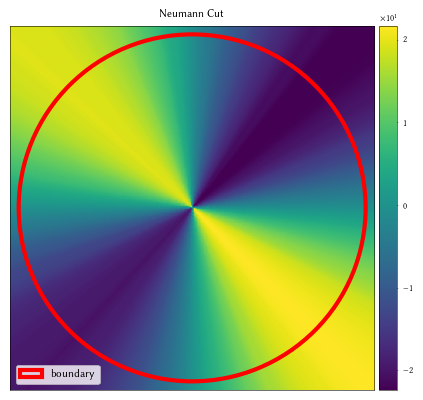

In [13]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
boundary_neumann[0].visualize(ax, bbox, resolution= resolution_image)
shape.sketch(ax, bbox, resolution_image)
ax.legend(loc="lower left", fontsize=8)
ax.set_title("Neumann Cut")

In [14]:
angle_partition1 = np.array([0, 3 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map1 = np.array([1, 0, 1, 0])

angle_partition2 = np.array([0, 3 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map2 = np.array([0, 1, 0, 1])
shape1 = CircleShape(origin=Point2f(0., 0.), radius=computation_radius, epsilon= epsilon,dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition1, dirichlet_map=dirichlet_map1)
data_holder1 = DataHolder(shape = shape1, σ=σ, f=f, α = α)

shape2 = CircleShape(origin=Point2f(0., 0.), radius=computation_radius, epsilon= epsilon,dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition2, dirichlet_map=dirichlet_map2)
data_holder2 = DataHolder(shape = shape2, σ=σ, f=f, α = α)

In [15]:
bbox_ = [[-1.05 * computation_radius, -1.05 * computation_radius], [1.05 * computation_radius, 1.05 * computation_radius]]
points = create_image_points(bbox_, resolution_image, spp_image)
wos1 = WostVariable(data_holder1, green_sampling = green, use_accelaration = use_accel, weight_window=weight_window)
L1, _= wos1.solve(points_in = points, split = split)
image1, tensor = create_image_from_result(L1, resolution_image)
wos2 = WostVariable(data_holder2, green_sampling = green, use_accelaration=use_accel, weight_window=weight_window)
L2, _ = wos2.solve(points_in = points, split = split)
image2, tensor = create_image_from_result(L2, resolution_image)

0 : 33554432 -> 4941862
1 : 4941862 -> 2121953
2 : 2121953 -> 934963
3 : 934963 -> 410714
4 : 410714 -> 181168
5 : 181168 -> 80157
6 : 80157 -> 35241
7 : 35241 -> 15487
8 : 15487 -> 6888
9 : 6888 -> 3032
10 : 3032 -> 1415
11 : 1415 -> 631
12 : 631 -> 263
13 : 263 -> 139
14 : 139 -> 59
15 : 59 -> 28
16 : 28 -> 17
17 : 17 -> 12
18 : 12 -> 5
19 : 5 -> 0
0 : 33554432 -> 8874118
1 : 8874118 -> 5353562
2 : 5353562 -> 3288205
3 : 3288205 -> 2016868
4 : 2016868 -> 1239716
5 : 1239716 -> 761993
6 : 761993 -> 467416
7 : 467416 -> 286599
8 : 286599 -> 176290
9 : 176290 -> 108186
10 : 108186 -> 66556
11 : 66556 -> 40891
12 : 40891 -> 24815
13 : 24815 -> 15129
14 : 15129 -> 9536
15 : 9536 -> 5721
16 : 5721 -> 3617
17 : 3617 -> 2235
18 : 2235 -> 1350
19 : 1350 -> 786
20 : 786 -> 487
21 : 487 -> 328
22 : 328 -> 219
23 : 219 -> 115
24 : 115 -> 68
25 : 68 -> 39
26 : 39 -> 27
27 : 27 -> 17
28 : 17 -> 14
29 : 14 -> 10
30 : 10 -> 2
31 : 2 -> 1
32 : 1 -> 0


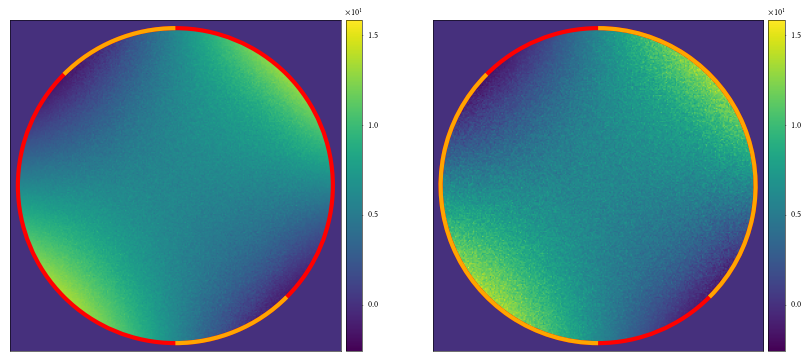

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])
max_val = max(image1.max(), image2.max())
min_val = min(image1.min(), image2.min())
range_ = [min_val, max_val]
plot_image(image1[0], ax1, input_range=range_)
shape1.sketch(ax1, bbox_, resolution_image)
plot_image(image2[0], ax2, input_range=range_)
shape2.sketch(ax2, bbox_, resolution_image)

Mean:
0.0100693405
Variance:
0.3010916


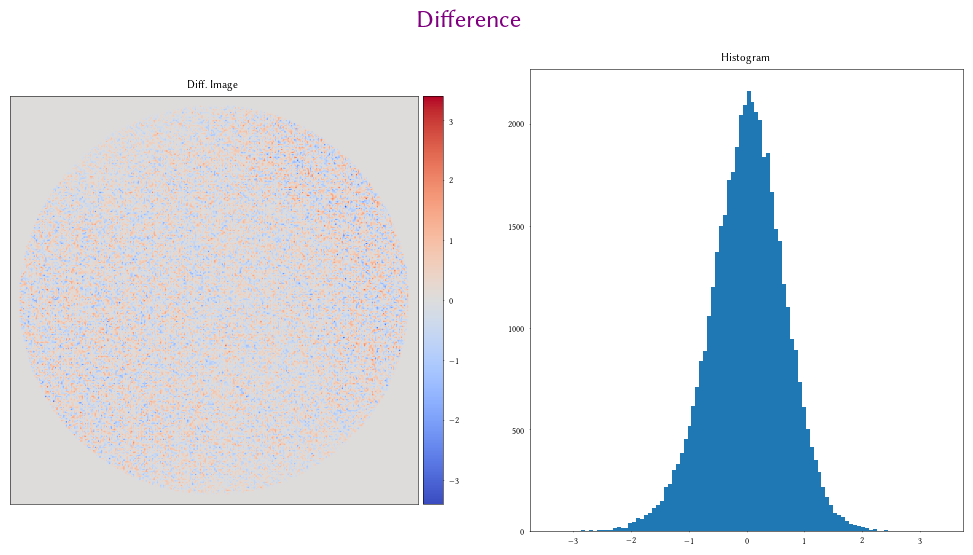

In [19]:
sketch_diff(image1[0], image2[0], max_range = 5)